<a href="https://colab.research.google.com/github/xAn-x/Cifar-10-image-classification/blob/master/Image_Classification_using_advance_techniques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms
from torch.utils.data import DataLoader, random_split

In [ ]:
# Transforms : Helps in data Augmentation

# Channel Normalization of images
mean,std=(0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)

my_transforms=transforms.Compose([
    transforms.RandomCrop(32,padding=4,padding_mode='reflect'),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1,contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean = mean,std=std)
])

In [ ]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=my_transforms)

# No transforms here as we will use it for Testing
val_dataset=datasets.CIFAR10(root='./data', train=False, download=False,transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean,std)]))

Files already downloaded and verified


In [ ]:
train_dataset[0]

(tensor([[[-0.1416, -0.6457, -0.1416,  ..., -0.4130, -0.7620, -1.6731],
          [-0.9752, -1.1303, -0.9752,  ..., -0.0253, -0.4906, -1.2854],
          [-1.7312, -1.7894, -1.7312,  ...,  0.0134, -0.3355, -0.8201],
          ...,
          [-0.5875, -0.8395, -0.5875,  ...,  1.2153,  1.0602,  0.8470],
          [-1.3435, -1.4017, -1.3435,  ...,  1.1571,  1.2928,  1.3510],
          [-1.3435, -1.7700, -1.3435,  ...,  0.8276,  1.0602,  1.3510]],
 
         [[-0.7662, -1.1989, -0.7662,  ..., -1.1792, -1.3562, -2.0053],
          [-1.4939, -1.5726, -1.4939,  ..., -0.8646, -1.1399, -1.7692],
          [-2.1823, -2.1233, -2.1823,  ..., -0.8252, -0.9826, -1.3759],
          ...,
          [-1.1989, -1.3759, -1.1989,  ...,  0.5121,  0.3548, -0.0582],
          [-1.7889, -1.7299, -1.7889,  ...,  0.5908,  0.6694,  0.5121],
          [-1.8282, -2.0249, -1.8282,  ...,  0.2564,  0.4138,  0.4531]],
 
         [[-1.2849, -1.5190, -1.2849,  ..., -1.6556, -1.7141, -2.1043],
          [-1.7531, -1.7141,

In [ ]:
# Getting labels corresponding to each integer val
labels=train_dataset.classes

print(labels)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
# Create Dataloader for training ,validation and testing usin coresspoding datasets

batch_size=256
train_loader=DataLoader(train_dataset,batch_size,shuffle=True,num_workers=2,pin_memory=True)
val_loader=DataLoader(val_dataset,batch_size,shuffle=True,num_workers=2,pin_memory=True)

In [ ]:
# Visualize batch of data

In [ ]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torch

In [ ]:
# since we have Normalized the images of training data, to visualize em we first need to de-norm them
def denormalize(images):
  means=torch.tensor(mean).reshape(1,3,1,1)
  standar_devs=torch.tensor(std).reshape(1,3,1,1)

  return images * standar_devs + means

In [ ]:
def visualize_batch(dataloader,denorm=False,seed=42):
    # For Reproducibility
    torch.manual_seed(seed)

    for images,_ in dataloader:
      # If images are normalized
      if denorm:
        images=denormalize(images)

      grid=make_grid(images,nrow=16)
      plt.figure(figsize=(10,16))
      plt.imshow(grid.permute(1,2,0))
      plt.axis(False)
      plt.show()
      break


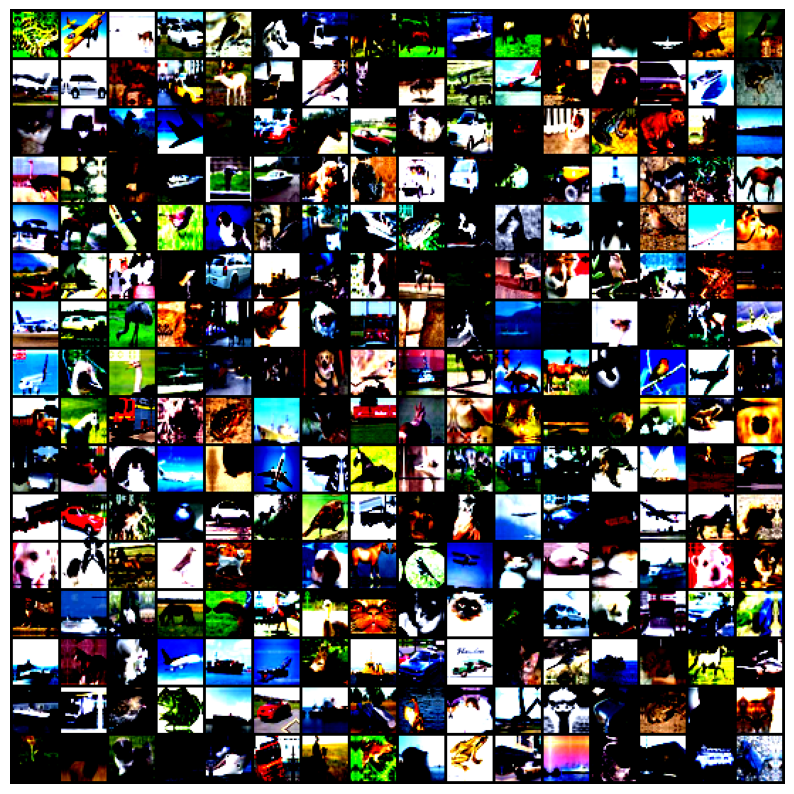

In [ ]:
# Without Denormalizing
visualize_batch(train_loader)

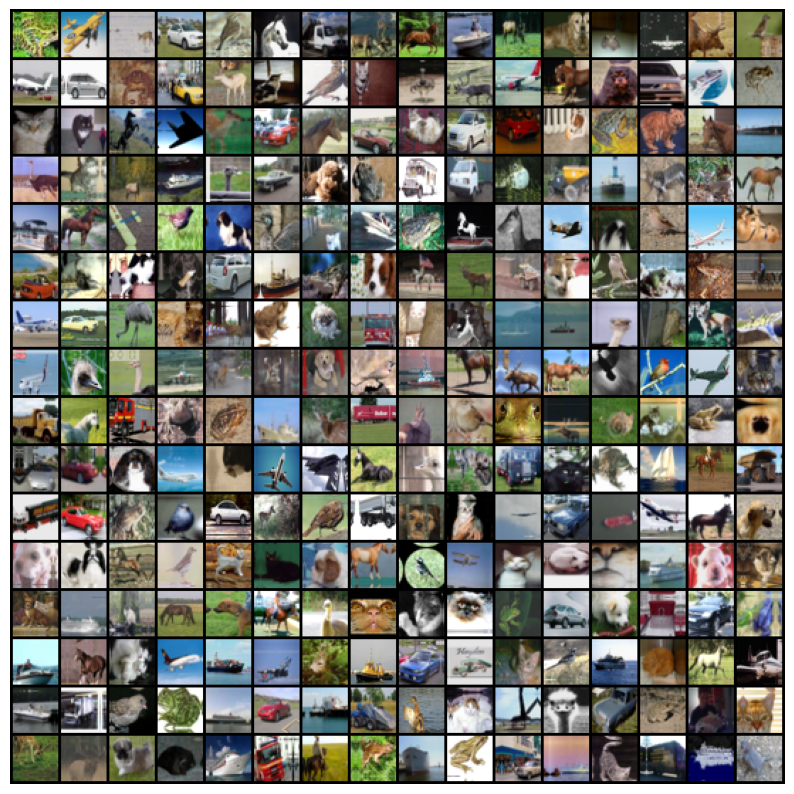

In [ ]:
# After De-Normalizing the images
visualize_batch(train_loader,denorm=True)

In [ ]:
# Model Training

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# Since Image-Classification is a general task in Deep learning we tends to make a helper class that we can use whenever require
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss.detach(), 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['lrs'][-1], result['train_loss'], result['val_loss'], result['val_acc']))

In [ ]:
# Using Residual Block to improve the classification

### ```Residual Block```

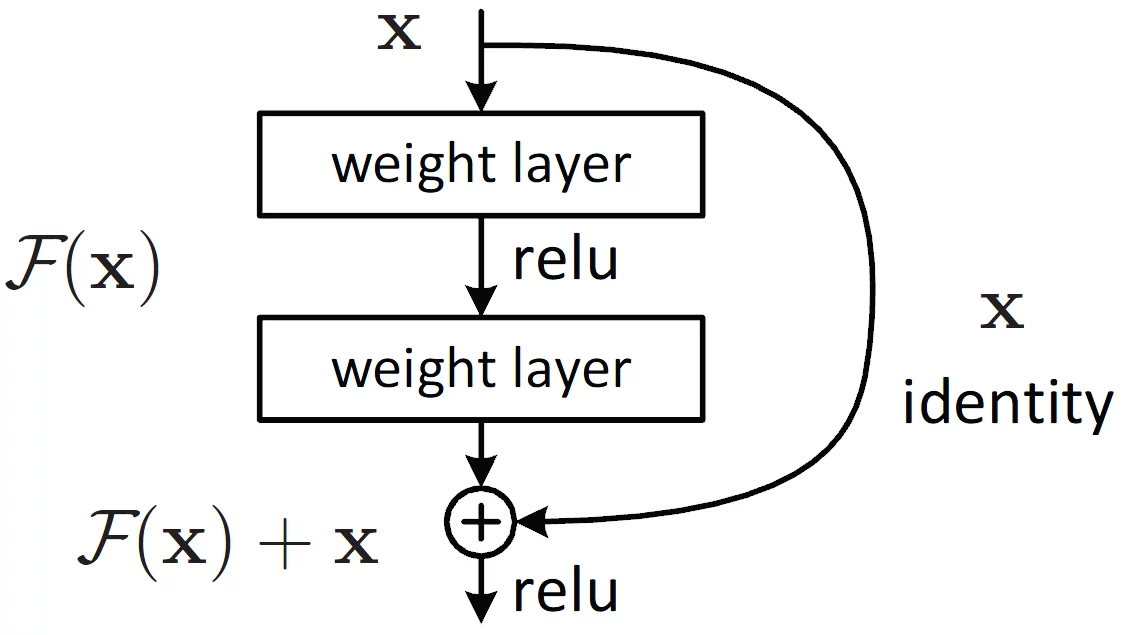

In [ ]:
# This is the simple IMplementation Of Residual Block
class ResidualBlock(nn.Module):
  def __init__(self,inp_channels=3,out_channels=3):
    super(ResidualBlock,self).__init__()
    self.net=nn.Sequential(
        nn.Conv2d(inp_channels,out_channels,kernel_size=3,stride=1,padding=1),
        nn.ReLU(),
        nn.Conv2d(inp_channels,out_channels,kernel_size=3,stride=1,padding=1),
        nn.ReLU()
    )

  def forward(self,x):
    return self.net(x)+x

In [ ]:
# =========== Checking ResBlock ===========

resBlock=ResidualBlock().to(torch.device('cuda'))

for images,_ in train_loader:
  print("Input-Shape: ",images.shape)
  out=resBlock(images.to(torch.device('cuda')))
  print("Output-Shape: ",out.shape)
  break


# Clear all the data in GPU before # Clear all the data in GPU before procedding ahead
del resBlock
torch.cuda.empty_cache()

Input-Shape:  torch.Size([256, 3, 32, 32])
Output-Shape:  torch.Size([256, 3, 32, 32])


### ```Using Resnet9 architecture```

* More More Details visit:
https://myrtle.ai/learn/how-to-train-your-resnet/


### ```Architecture```
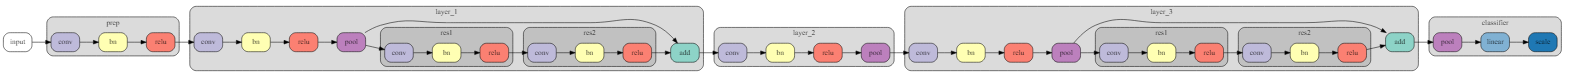

In [ ]:
# Convulational Block : to avoid writing same code again and again
def convBlock(in_channels,out_channels,pool=False):
  layers=[
      nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=1,padding=1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
  ]

  if pool:
    layers.append(nn.MaxPool2d(2))

  return nn.Sequential(*layers)

In [ ]:
class MyResNet9(ImageClassificationBase):
  def __init__(self,in_channels,num_classes):
    super(MyResNet9,self).__init__()

    self.conv1 = convBlock(in_channels, 64)
    self.conv2 = convBlock(64, 128, pool=True)
    self.res1 = nn.Sequential(convBlock(128, 128), convBlock(128, 128))

    self.conv3 = convBlock(128, 256, pool=True)
    self.conv4 = convBlock(256, 512, pool=True)
    self.res2 = nn.Sequential(convBlock(512, 512), convBlock(512, 512))

    self.classifier = nn.Sequential(nn.MaxPool2d(4),
                                    nn.Flatten(),
                                    nn.Dropout(0.2),
                                    nn.Linear(512, num_classes))

  def forward(self, xb):
    out = self.conv1(xb)
    out = self.conv2(out)
    out = self.res1(out) + out
    out = self.conv3(out)
    out = self.conv4(out)
    out = self.res2(out) + out
    out = self.classifier(out)
    return out

In [ ]:
# Helper Functions that will help us move our model and tensor to device (gpu/cpu)

def get_default_device():
  return torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


def to_device(x,device):
  if (isinstance(x,(list,tuple))):
    return [to_device(ele,device) for ele in x]
  return x.to(device)

class DeviceDataLoader():
  def __init__(self,data_loader,device):
    super().__init__()
    self.data_loader=data_loader
    self.device=device

  def __len__(self):
    return len(self.data_loader)

  def __iter__(self):
    for batch in self.data_loader:
      yield to_device(batch,self.device)

In [ ]:
torch.manual_seed(13)

In [ ]:
# Getting Device
device=get_default_device()

In [ ]:
# Moving Dataloader -> DeviceDataLoader

train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [ ]:
# moving model to device
model = to_device(MyResNet9(3, 10), device)
model

MyResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (conv3): Sequential(
    (0): 

### ```Training using some advance techniques```

* ```Learning Rate scheduling:```

Learning rate scheduling is a technique used in training machine learning models, particularly in optimization algorithms like stochastic gradient descent (SGD). It involves dynamically adjusting the learning rate during training to enhance convergence and improve performance. Common strategies include reducing the learning rate over time, for example, by decay schedules such as step decay, exponential decay, or cosine annealing. Learning rate scheduling aims to strike a balance between fast convergence in the early stages of training and fine-tuning in later stages.



* ```Weight Decay:```

Weight decay is a regularization technique used to prevent overfitting during the training of machine learning models, particularly in neural networks. It involves adding a penalty term to the loss function proportional to the squared magnitudes of the model's weights. This penalty discourages the model from relying too much on specific weights, promoting a more generalized and simpler model. By introducing weight decay, the optimization process seeks to find a solution that balances fitting the training data well and avoiding overly complex models that might not generalize effectively to new, unseen data.

* ```Gradient Clipping:```

Gradient clipping is a technique employed during the training of machine learning models to address the problem of exploding gradients. It involves setting a threshold value, and if the gradients of the model parameters exceed this threshold during backpropagation, they are scaled down to meet the limit. This prevents extremely large gradient values that could destabilize the training process, ensuring more stable and reliable model updates. Gradient clipping is commonly used in optimization algorithms, such as stochastic gradient descent (SGD), to improve the numerical stability of the training process, particularly in deep neural networks.

It Improve the model performance by a lot ,without it @ around 10 epoch the accuraccy was about 76% but with it the accuraccy jumps to 74% @ around 8th epoch


In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [ ]:
def fit(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, opt_func=torch.optim.SGD,grad_clip_value=None):

    # Clear cache if already contain something
    torch.cuda.empty_cache()
    history = []

    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)

    # Set up one-cycle learning rate scheduler
    # Learn about once-cycle learning rate scheduler policy here: https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Ising Gradient clipping
            if grad_clip_value:
                torch.nn.utils.clip_grad_value_(model.parameters(), grad_clip_value)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            scheduler.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)


    return history

In [ ]:
history = [evaluate(model, val_loader)]

In [ ]:
print(f"Initial Loss and accuraccy:\n{history[0]}")

Initial Loss and accuraccy:
{'val_loss': 2.3027420043945312, 'val_acc': 0.09765625}


In [ ]:
# Parameters

epochs = 12
max_lr = 0.01
# Regularization
weight_decay = 1e-3
# Gradient Clipping
grad_clip_value=0.2
opt_func = torch.optim.Adam

In [ ]:
%%time
history += fit(epochs, max_lr, model, train_loader, val_loader, weight_decay, opt_func,grad_clip_value)

Epoch [0], last_lr: 0.00210, train_loss: 1.4163, val_loss: 1.1788, val_acc: 0.5997
Epoch [1], last_lr: 0.00602, train_loss: 1.0034, val_loss: 1.1039, val_acc: 0.6104
Epoch [2], last_lr: 0.00936, train_loss: 0.9320, val_loss: 1.2587, val_acc: 0.5795
Epoch [3], last_lr: 0.00994, train_loss: 0.8422, val_loss: 1.4959, val_acc: 0.5580
Epoch [4], last_lr: 0.00933, train_loss: 0.8138, val_loss: 1.4874, val_acc: 0.5167
Epoch [5], last_lr: 0.00812, train_loss: 0.7654, val_loss: 1.0814, val_acc: 0.6253
Epoch [6], last_lr: 0.00647, train_loss: 0.7272, val_loss: 1.1605, val_acc: 0.5979
Epoch [7], last_lr: 0.00463, train_loss: 0.6692, val_loss: 0.8833, val_acc: 0.7116
Epoch [8], last_lr: 0.00283, train_loss: 0.5906, val_loss: 0.5996, val_acc: 0.7937
Epoch [9], last_lr: 0.00133, train_loss: 0.4897, val_loss: 0.5201, val_acc: 0.8256
Epoch [10], last_lr: 0.00035, train_loss: 0.3840, val_loss: 0.3510, val_acc: 0.8784
Epoch [11], last_lr: 0.00000, train_loss: 0.3029, val_loss: 0.3184, val_acc: 0.8913
CP

In [ ]:
def plot_loss(history):
    train_losses = [x.get(f'train_loss') for x in history]
    val_losses = [x[f'val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epochs')
    plt.ylabel("losses")
    plt.legend(['Training', 'Validation'])
    plt.title(f'loss vs. No. of epochs');

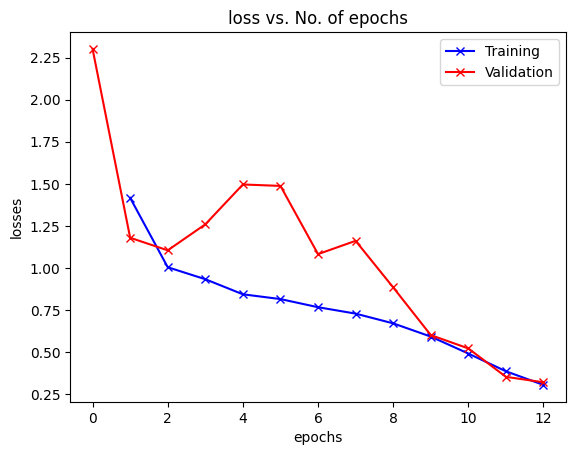

In [ ]:
plot_loss(history)

In [ ]:
def plot_acc(history):
  accuracies = [x['val_acc'] for x in history]
  plt.plot(accuracies, '-x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Accuracy vs. No. of epochs')

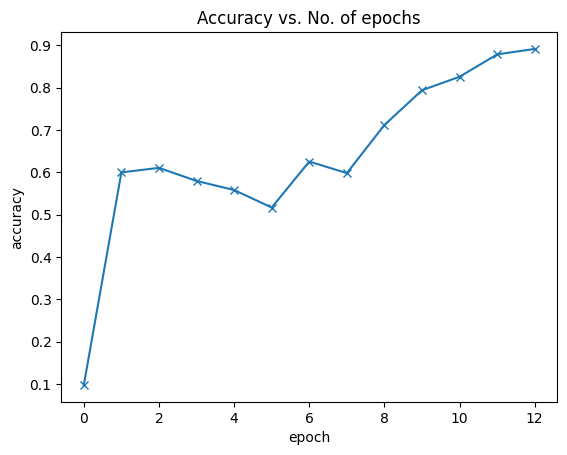

In [ ]:
plot_acc(history)

In [ ]:
import numpy as np
def plot_lr(history):
    lr = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lr)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

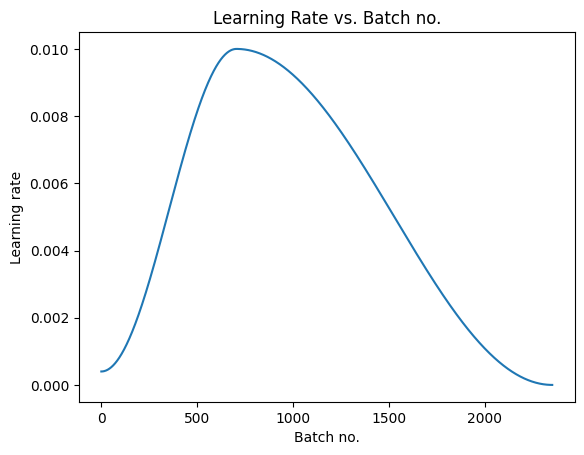

In [ ]:
plot_lr(history)

### ```Saving the model```

In [ ]:
# mount notebook to gdrive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#  save model to dir
path="/content/drive/MyDrive/Datasets/Cifar-10/cifar-10.pth"
torch.save(model.state_dict(),path)

[NbConvertApp] WARNING | pattern 'notebook.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Ex